<img src="https://raw.githubusercontent.com/CristianR8/Imagenes-Espectrales-Sesion4-Parte1-HoCV/main/images/banner-spectral.png" width="1000" align="middle"/>

# <font color='#ECA702'>**Demo target detection🎯**</font>

Reference: [Spectral Matching and Target Detection Techniques](https://www.mathworks.com/help/images/target-detection-and-spectral-matching-techniques.html)

##Carga de los datos

In [ ]:
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
%%capture
!pip install gdown
!gdown --id 1qElBEdiEAbwI8MUd6Gq0BEZiw9mSwD_V -O /content/data.zip
!unzip /content/data.zip -d /content/data

In [ ]:
import gdown
def load_from_drive(file_id, name):
  gdown.download(id=file_id, output=name, quiet=False)
  return name

In [ ]:
load_from_drive('1w93WWvoCWvhleF6X2dk1S7pBZnbpR4Ao', 'coffee_gt')

Downloading...
From: https://drive.google.com/uc?id=1w93WWvoCWvhleF6X2dk1S7pBZnbpR4Ao
To: /content/coffee_gt
100%|██████████| 249k/249k [00:00<00:00, 34.1MB/s]


'coffee_gt'

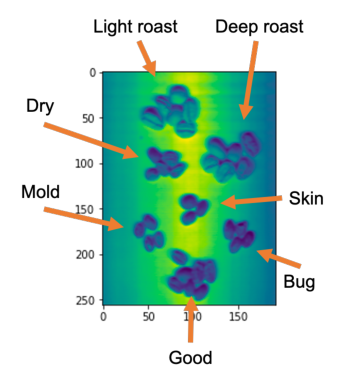

In [ ]:
from PIL import Image
import numpy as np

coffee_gt = Image.open('coffee_gt')
coffee_gt = np.array(coffee_gt)
plt.imshow(coffee_gt)
plt.axis('off')
plt.show()

In [ ]:
folder_path = "/content/data/coffee"

image_files = sorted(glob.glob(folder_path + "/*.png"))

spectral_cube = np.array([np.array(Image.open(img)) for img in image_files])
spectral_cube = np.transpose(spectral_cube, (1, 2, 0))

print(f"Cubo espectral generado con forma: {spectral_cube.shape}")

Cubo espectral generado con forma: (256, 192, 96)


##Procesamiento

In [ ]:
#FILTROS

from scipy.ndimage import median_filter, gaussian_filter
# Filtro mediana en cada banda para eliminar ruido granular
spectral_cube = median_filter(spectral_cube, size=(3, 3, 1))
# Filtro Gaussiano para suavizar detalles no deseados
spectral_cube = gaussian_filter(spectral_cube, sigma=(0, 0, 1))

In [ ]:
#NORMALIZACIÓN
p_low, p_high = np.percentile(spectral_cube, (2, 98), axis=(0, 1), keepdims=True)
spectral_cube = (spectral_cube - p_low) / (p_high - p_low + 1e-6)
spectral_cube = np.clip(spectral_cube, 0, 1)

In [ ]:
#PCA (Principal Component Analisys)
from sklearn.decomposition import PCA

num_bands = spectral_cube.shape[2]
pca = PCA(n_components=num_bands - 5)  # Reducimos 5 bandas de menor relevancia
spectral_cube_pca = pca.fit_transform(spectral_cube.reshape(-1, num_bands))
spectral_cube_pca = spectral_cube_pca.reshape(spectral_cube.shape[0], spectral_cube.shape[1], -1)

##Visualización

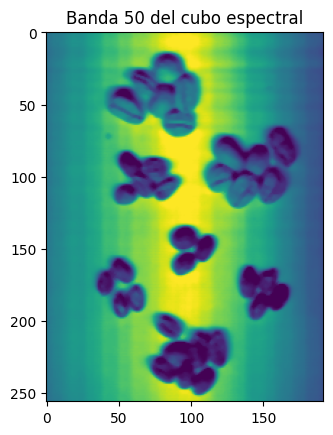

In [ ]:
band = 50
plt.imshow(spectral_cube[:, :, band])
plt.title(f'Banda {band} del cubo espectral')
plt.show()

##Selección de objetivo

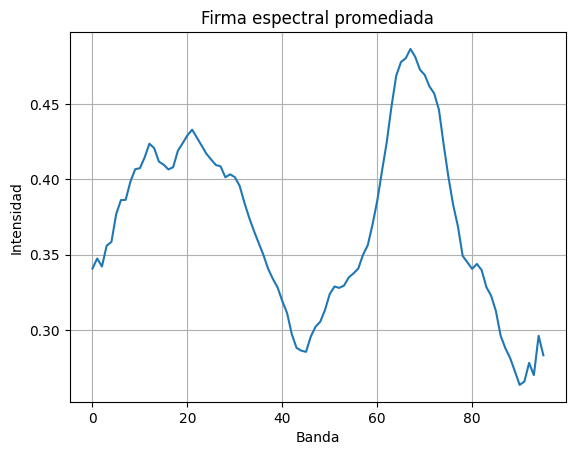

In [ ]:
pixel_x = 50
pixel_y = 75
window_size = 5
x_min, x_max = pixel_x - window_size//2, pixel_x + window_size//2
y_min, y_max = pixel_y - window_size//2, pixel_y + window_size//2

spectral_signature = np.mean(spectral_cube[x_min:x_max, y_min:y_max, :], axis=(0, 1))

plt.plot(spectral_signature)
plt.xlabel("Banda")
plt.ylabel("Intensidad")
plt.title("Firma espectral promediada")
plt.grid()
plt.show()

## HSI detectors

In [ ]:
def smf_detector(x,tgt_sig,mu=None,siginv=None):

	pix = topix(x)
	n_pix,n_band = pix.shape

	if mu is None:
		mu = pix.mean(axis=0)
	if siginv is None:
		sig = np.cov(pix.T)
		siginv = np.linalg.inv(sig)

	s = tgt_sig - mu
	z = pix - mu
	f = s.dot(siginv) / math.sqrt(s.dot(siginv.dot(s)))
	smf_data = z.dot(f)

	return toimg(smf_data,x,2)

def topix(x):
	return x.reshape( (x.shape[0]*x.shape[1],x.shape[2]) )

def toimg(pix,x,n_dim=None):
	if n_dim is None:
		n_dim = len(x.shape)

	return pix.reshape(x.shape[:n_dim])

def ace_detector(x,tgt_sig,mu=None,siginv=None):

	pix = topix(x)
	n_pix,n_band = pix.shape

	if mu is None:
		mu = pix.mean(axis=0)
	if siginv is None:
		sig = np.cov(pix.T)
		siginv = np.linalg.inv(sig)

	s = tgt_sig - mu
	z = pix - mu
	st_siginv = s.dot(siginv)

	A = z.dot(st_siginv)
	B = np.sqrt(st_siginv.dot(s))
	C = np.sqrt(np.sum(z * z.dot(siginv.T), axis=1))
	ace_data = A/(B*C)

	return toimg(ace_data,x,2)

##Resultados

In [ ]:
conf_ace = smf_detector(spectral_cube,spectral_signature)

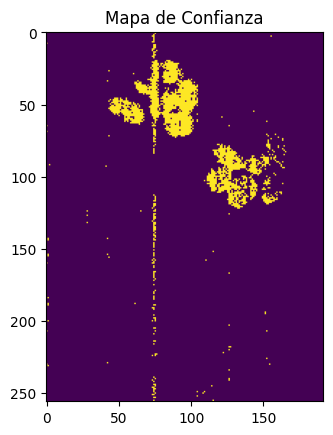

In [ ]:
plt.imshow(conf_ace>2)
plt.title('Mapa de Confianza')
plt.show()

#References
[Near Infrared Hyperspectral Image Dataset](https://www.kaggle.com/datasets/hacarus/near-infrared-hyperspectral-image)